In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sn
import sys
import os
from pathlib import Path
from tqdm import tqdm
from timeit import default_timer as timer
from datetime import timedelta

import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchmetrics.classification import BinaryCalibrationError

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibrationDisplay
from sklearn.calibration import calibration_curve

# import custom functions from src folder
module_path = str(Path.cwd() / "../../../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from evidential import *
from util import *


In [2]:
sn.set_palette("tab10")
sn.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [3]:
def label_maker(values, num_classes):
    labels = np.zeros((len(values), num_classes))
    for i, value in enumerate(values):
        labels[i][value] = 1
    return torch.Tensor(labels).to(torch.int)

In [4]:
# Set up device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device {torch.cuda.get_device_name(1)}")

Using cuda device NVIDIA TITAN V


In [5]:
# Machine learning options
x1_key = "x1"
x2_key = "x2"
n_data = [250, 500, 1000, 2000, 3000, 5000, 10000]
bs_list = [128, 128, 128*2, 128*2, 1024, 1024, 1024*2]
#n_data = [10000]
max_err_val = [0]*len(n_data)
for i in range(len(n_data)):
    if n_data[i] < 1000:
        max_err_val[i] = 0.5
    else:
        max_err_val[i] = 0.25
patience = 30
load_values = False
save_values = True

#Data constants
shapes = [2, 6]
scales = [5, 3]
k = len(scales) # Number of classes
d = 2 # Number of dimensions
p_c = [1/len(shapes)]*len(shapes) # Uniform distributon over classes
grid_rmax=40

tag = f'k_{k}_d{d}_shapes{shapes}_scales{scales}_pc{p_c}'.replace(" ", "")

# Read files
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
valfile = f"val_n_5000_{tag}"
testfile = f"test_n_10000_{tag}"
gridfile = f"grid_x1_x2_10000_{tag}"

train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
grid_data = pd.read_csv(f"../data/{gridfile}.csv")

X_train = torch.Tensor(np.dstack((train_data[x1_key], train_data[x2_key]))).to(torch.float32)[0]
Y_train = label_maker(train_data["class"], 2)

X_val = torch.Tensor(np.dstack((val_data[x1_key], val_data[x2_key]))).to(torch.float32)[0]
Y_val = label_maker(val_data["class"], 2)

X_test = torch.Tensor(np.dstack((test_data[x1_key], test_data[x2_key]))).to(torch.float32)[0]
Y_test = label_maker(test_data["class"], 2)

X_grid = torch.Tensor(np.dstack((grid_data[x1_key], grid_data[x2_key]))).to(torch.float32)[0]
Y_grid = torch.zeros(X_grid.shape)

In [6]:
# Create datasets for pytorch
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
grid_dataset = torch.utils.data.TensorDataset(X_grid, Y_grid)

In [7]:
model = SequentialNet(L=200, n_hidden=5, activation="relu", in_channels=2, out_channels=2).to(device)
#model = SequentialNet(L=5000, n_hidden=4, activation="relu", in_channels=2, out_channels=2).to(device)
model # Check that everything looks good

SequentialNet(
  (hidden_layers): Sequential(
    (0): Linear(in_features=200, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=200, bias=True)
    (7): ReLU()
    (8): Linear(in_features=200, out_features=200, bias=True)
    (9): ReLU()
  )
  (first_layer): Linear(in_features=2, out_features=200, bias=True)
  (last_layer): Linear(in_features=200, out_features=2, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

100%|██████████| 100/100 [00:00<00:00, 464.00it/s]


Text(0.5, 0.98, 'Number of training datapoints: 0')

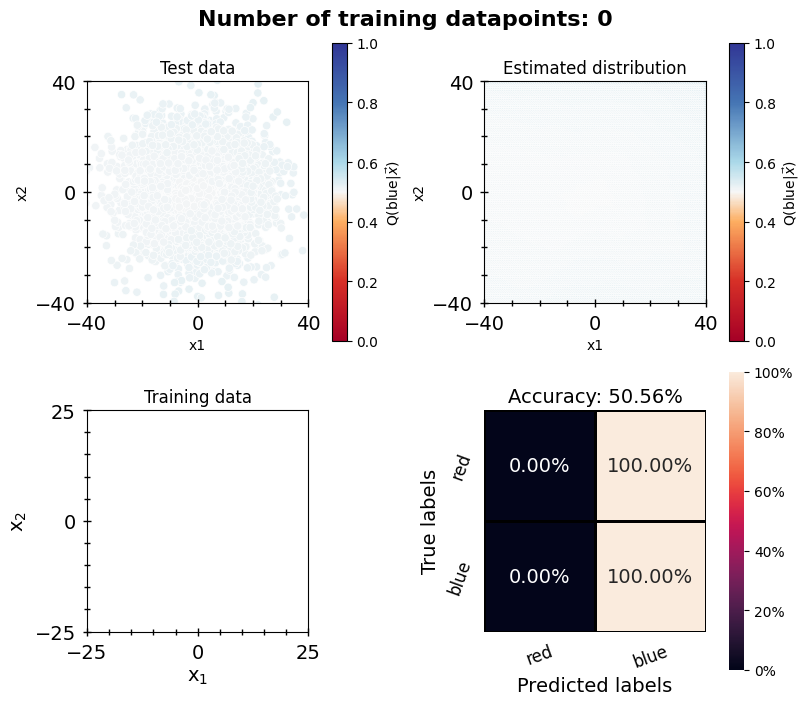

In [9]:
probs, uncertainties, beliefs = predict_evidential_classifier(model, val_dataset, 2, 100, device)
preds = torch.argmax(probs, dim=-1).flatten()
val_data["Prediction"] = preds
val_data["Est_prob_blue"] = probs[:,1] #Get softmax score for blue

probs, uncertainties, beliefs = predict_evidential_classifier(model, grid_dataset, 2, 100, device)
preds = torch.argmax(probs, dim=-1).flatten()
grid_data["Prediction"] = preds
grid_data["Est_prob_blue"] = probs[:,1] #Get softmax score for blue

# Plot
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

axs[0][0] = plot_results(val_data, "Est_prob_blue", axs[0][0], "Test data", rmax=grid_rmax)
axs[0][1] = plot_results(grid_data, "Est_prob_blue", axs[0][1], "Estimated distribution", rmax=grid_rmax)
axs[1][1] = plot_conf_matrix(val_data, "class", "Prediction", ["red", "blue"], axs[1][1])
axs[1][0] = plot_data(train_data[0:0], axs[1][0], "Training data")

cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

fig.suptitle(f"Number of training datapoints: 0", size=16, fontweight="bold")

 49%|████▉     | 49/100 [01:27<01:31,  1.80s/it]


Stopping training early at epoch 49


100%|██████████| 100/100 [00:00<00:00, 469.70it/s]


<Axes: xlabel='Iteration'>

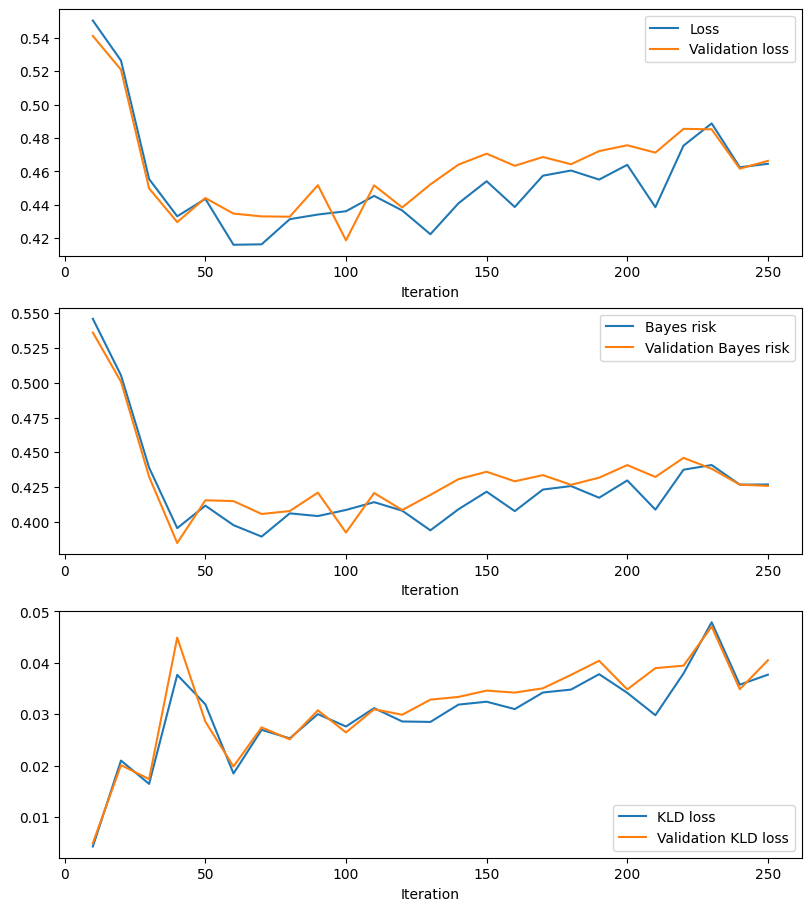

In [10]:
n_train = 10000
patience = 30
epochs = 100
lr = 0.001
batchsize = 1024*2

optimizer = optim.Adam(model.parameters(), lr=lr)

train_dataset_small = torch.utils.data.TensorDataset(X_train[0:n_train], Y_train[0:n_train])
training_results = train_evidential_classifier(model, train_dataset_small, 
                         val_dataset, batchsize=batchsize, epochs = epochs, 
                         device = device, optimizer = optimizer, early_stopping=patience)
probs, uncertainties, beliefs = predict_evidential_classifier(model, test_dataset, 2, 100, device)
preds = torch.argmax(probs, dim=-1).flatten()
fig, axs = plt.subplots(nrows = 3, ncols = 1, figsize = (8, 3*3), layout="constrained")
training_results.plot("Iteration", ["Loss", "Validation loss"], ax=axs[0])
training_results.plot("Iteration", ["Bayes risk", "Validation Bayes risk"], ax=axs[1])
training_results.plot("Iteration", ["KLD loss", "Validation KLD loss"], ax=axs[2])

100%|██████████| 100/100 [00:00<00:00, 457.14it/s]


Text(0.5, 0.98, 'Number of training datapoints: 10000')

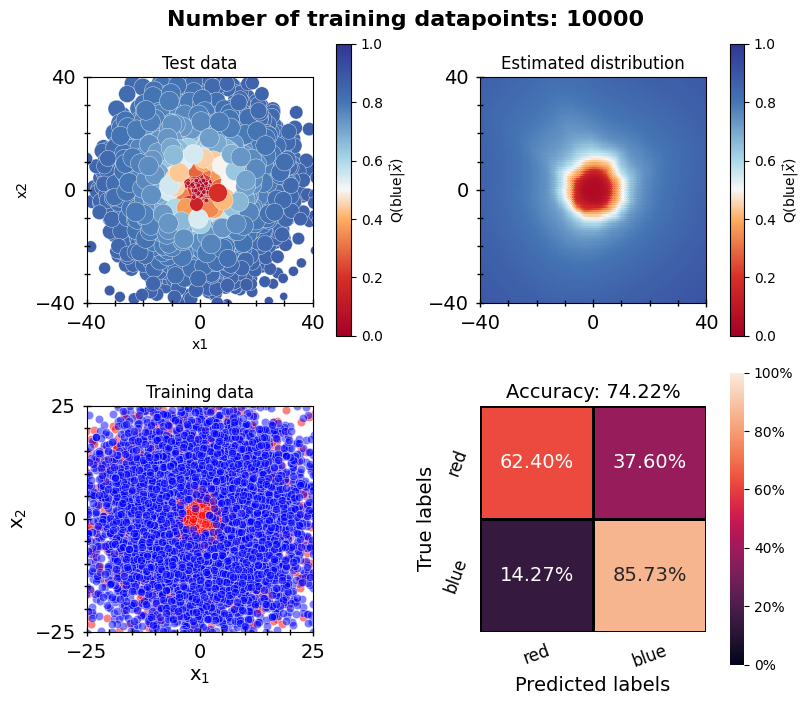

In [13]:
probs, uncertainties, beliefs = predict_evidential_classifier(model, test_dataset, 2, 100, device)
preds = torch.argmax(probs, dim=-1).flatten()
test_data["Prediction"] = preds
#Get softmax score for blue
test_data["Est_prob_blue"] = probs[:,1]
test_data["Uncertainty"] = uncertainties[:,1]
test_data["0.5_uncertainty"] = uncertainties[:,1]/2
test_data["Beliefs"] = beliefs[:,1]

probs, uncertainties, beliefs = predict_evidential_classifier(model, grid_dataset, 2, 100, device)
preds = torch.argmax(probs, dim=-1).flatten()
grid_data["Prediction"] = preds
#Get softmax score for blue
grid_data["Est_prob_blue"] = probs[:,1]
grid_data["Uncertainty"] = uncertainties[:,1]
grid_data["0.5_uncertainty"] = uncertainties[:,1]/2
grid_data["Beliefs"] = beliefs[:,1]

# Plot
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

axs[0][0] = plot_results(test_data, "Est_prob_blue", axs[0][0], "Test data", error_key="0.5_uncertainty", rmax=grid_rmax)
axs[0][1] = plot_results(grid_data, "Est_prob_blue", axs[0][1], "Estimated distribution", grid=True, rmax=grid_rmax)
axs[1][1] = plot_conf_matrix(test_data, "class", "Prediction", ["red", "blue"], axs[1][1])
axs[1][0] = plot_data(train_data[0:n_train], axs[1][0], "Training data")


cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

fig.suptitle(f"Number of training datapoints: {n_train}", size=16, fontweight="bold")


<Axes: xlabel='r', ylabel='Count'>

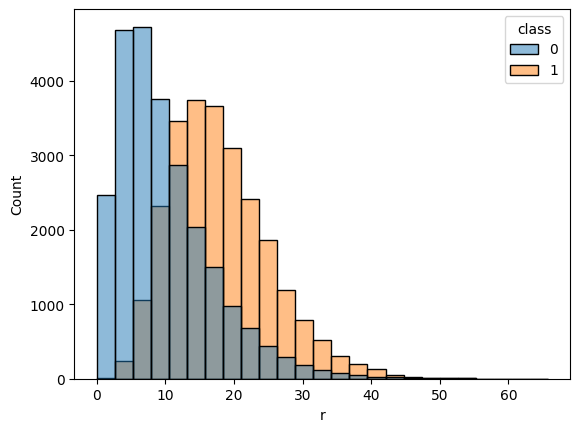

In [16]:
sn.histplot(train_data, x="r", hue="class", bins=25)
#plt.xlim(25, 30)
#plt.ylim(0, 30)

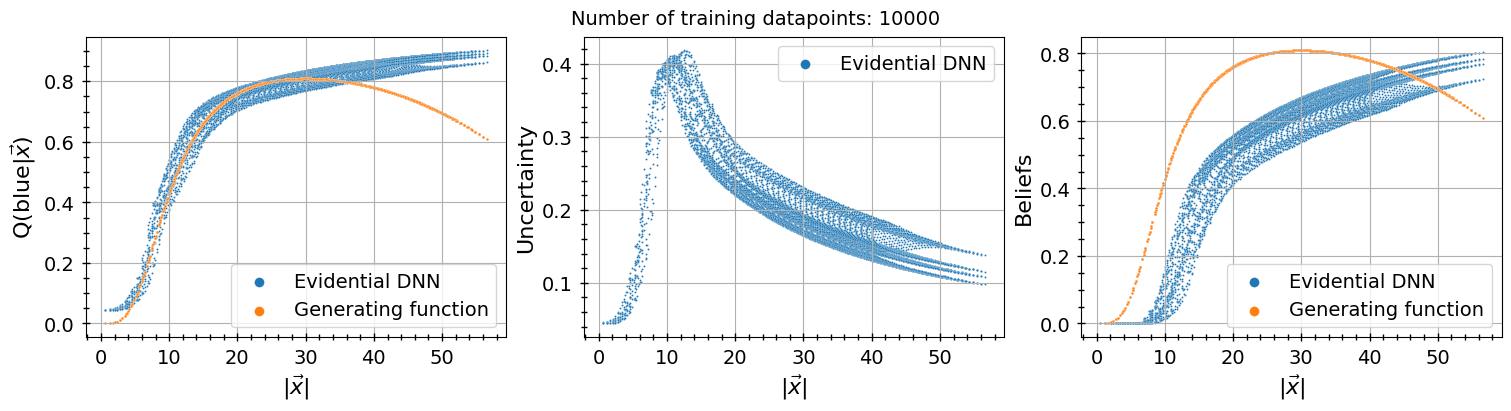

In [18]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize= (5*3, 4), layout="constrained")

sn.scatterplot(grid_data, x="r", y="Est_prob_blue", s=2, ax = axs[0], label ="Evidential DNN")
sn.scatterplot(grid_data, x="r", y="p_c1_given_r", s=2, ax = axs[0], label="Generating function")
axs[0].set_ylabel(r"Q(blue|$\vec{x}$)", fontsize=16)

sn.scatterplot(grid_data, x="r", y="0.5_uncertainty", s=2, ax = axs[1], label ="Evidential DNN")
axs[1].set_ylabel(r"Uncertainty", fontsize=16)

sn.scatterplot(grid_data, x="r", y="Beliefs", s=2, ax = axs[2], label ="Evidential DNN")
sn.scatterplot(grid_data, x="r", y="p_c1_given_r", s=2, ax = axs[2], label="Generating function")
axs[2].set_ylabel(r"Beliefs", fontsize=16)

fig.suptitle(f"Number of training datapoints: {n_train}", fontsize=14)
for ax in axs:
    ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()
    ax.grid()
    ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
    ax.legend(markerscale=5, fontsize=14)

Text(0.5, 0.98, 'Number of training datapoints: 10000')

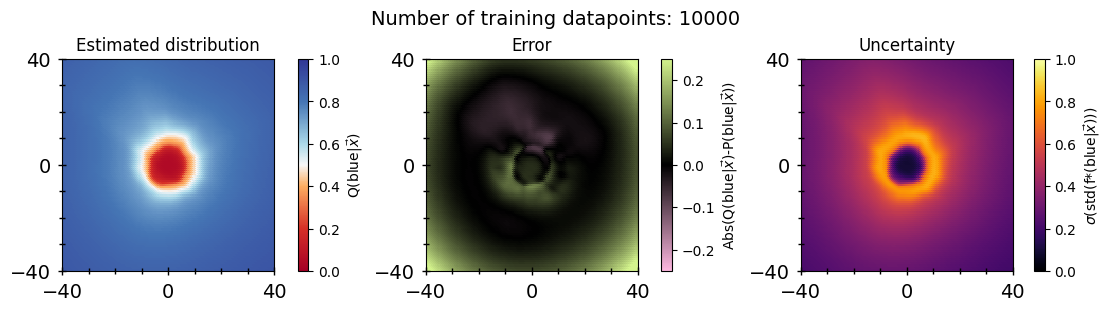

In [24]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (11,3), layout="constrained")

axs[0] = plot_results(grid_data, "Est_prob_blue", axs[0], "Estimated distribution", grid=True, rmax=grid_rmax)
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=red_blue_cmap()), label=r"Q(blue|$\vec{x}$)", ax=axs[0])

axs[1] = plot_diff(grid_data, grid_data, "Est_prob_blue", "p_c1_given_r", axs[1], r"Error", max_val=0.25, rmax=grid_rmax)
hue_norm = mpl.colors.Normalize(vmin=-0.25, vmax=0.25, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=pink_black_green_cmap()), label=r"Abs(Q(blue|$\vec{x}$)-P(blue|$\vec{x}$))", ax=axs[1])

axs[2] = plot_std(grid_data, "Uncertainty", axs[2], "Uncertainty", grid=True, max_val=1, rmax=grid_rmax)
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap="inferno"),  fraction=0.050, pad=0.04,
                label=r"$\sigma$(std(f*(blue|$\vec{x}$)))", ax=axs[2])

fig.suptitle(f"Number of training datapoints: {n_train}", fontsize=14)


Text(0.5, 0.98, 'Number of training datapoints: 10000')

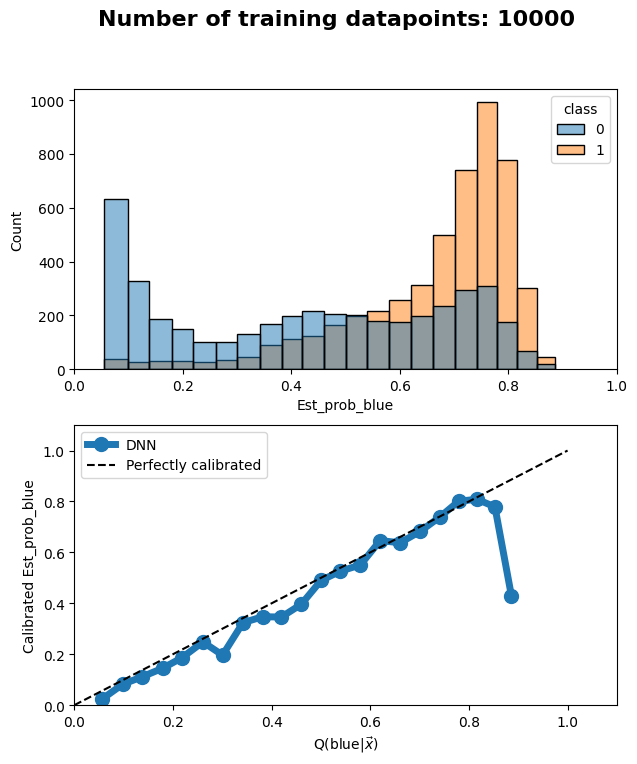

In [23]:
prob_cal, prob_pred = calibration_curve(test_data["class"], test_data["Est_prob_blue"], n_bins=25, strategy="uniform")
pred_bins=list(prob_pred)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 8))
sn.histplot(test_data, x="Est_prob_blue", hue="class", ax=ax[0], stat="count", bins=pred_bins)
ax[0].set_xlim(0,1)
ax[1].plot(prob_pred, prob_cal, linewidth=5, markersize=10, marker="o", label ="DNN")
ax[1].set_xlim(0,1.1)
ax[1].set_ylim(0,1.1)
x = np.linspace(0, 1, 10)
ax[1].plot(x, x, color="black", linestyle="--", label="Perfectly calibrated")
ax[1].set_xlabel(r"Q(blue|$\vec{x}$)")
ax[1].set_ylabel("Calibrated Est_prob_blue")
ax[1].legend()
fig.suptitle(f"Number of training datapoints: {n_train}", size=16, fontweight="bold")